<a href="https://colab.research.google.com/github/BriacLEGUILLOU/Impact_score/blob/master/Impact_score_pr%C3%A9paration_des_donn%C3%A9es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_rows', 60)

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
def obtention_log10(nb):
  """ Permet de convertir un nombre de la façon suivante :
  6 -> 1e6
  -6 -> -1e6 """
  signe = np.sign(nb)
  nb = np.absolute(nb)
  if nb == 0:
    return 0
  else :
    return math.log10(nb) * signe

# Chargement et préparation de bundle

In [ ]:
# Load of bundle
bundle_raw = pd.read_csv('/content/gdrive/My Drive/Impact Score/Data/bundle.csv', sep=';', header=None,  index_col=False, names =['siren', 'year', 'accountability', 'bundle','amount'], nrows=1000000)
bundle_raw.shape

(1000000, 5)

In [ ]:
# Identification des doublons
bundle_raw[bundle_raw.duplicated(subset=['siren', 'year', 'accountability', 'bundle'], keep='first')]


# On sélectionne uniquement les CR annuel complet, et on élimine certains doublons
bundle_raw = bundle_raw.loc[bundle_raw['accountability'] == 0,:].drop_duplicates(subset=['siren', 'year', 'accountability', 'bundle'], keep='first')

In [ ]:
# On charge le nom des colonnes
ontology = pd.read_json('http://api.enthic.fr/company/ontology')

# Création d'un dataframe contenant les colonnes de chaque type de bilan
df_col = pd.DataFrame(columns=[ontology.loc[i,:].iloc[0].get("1") for i in range(4)]+
                      ['liasse '+ ontology.loc[i,:].iloc[0].get("1") for i in range(4)],
                               index=range(68))

# Lecture de tous les comptes de résultats
for type_bilan in range(4):
    dictionnaire = ontology.loc[type_bilan,:].iloc[0].get("code")
    nb_col = len(dictionnaire)
    
    for i in range(nb_col):
        df_col.iloc[i,type_bilan] = dictionnaire.get(str(i)).get("1")
        df_col.iloc[i,type_bilan+4] = dictionnaire.get(str(i)).get("0")
  
col_CR_complet = df_col.loc[:,['Compte annuel complet','liasse Compte annuel complet']]
col_CR_complet

,Compte annuel complet,liasse Compte annuel complet
0,"Autres impôts, taxes et versements assimilés",9Z
1,Ventes de marchandises,FA
2,Production vendue biens,FD
3,Production vendue services,FG
4,Chiffres d’affaires nets,FJ
...,...,...
63,"Rétrocessions d’honoraires, commissions et cou...",YV
64,Taxe professionnelle,YW
65,Montant de la TVA. collectée,YY
66,Total TVA. déductible sur biens et services,YZ


In [ ]:
# On transforme la structure des données
bundle = pd.DataFrame(columns = ['year'] + list(range(0, 68)))
for year in sorted(bundle_raw['year'].unique()):
    bundle_year = bundle_raw.loc[bundle_raw['year']==year,:].pivot(index='siren', columns='bundle', values='amount').applymap(lambda x: obtention_log10(x))
    bundle_year['year'] = year
    bundle = pd.concat([bundle,bundle_year])


bundle = bundle.astype(float)

bundle.columns = ['year'] + list(col_CR_complet['Compte annuel complet'])
bundle['siren'] = bundle.index
print(bundle)
# La nouvelle forme des données est [111013 rows x 68 columns] = 7M de celulles
# L'ancienne forme des données était [3000000 rows x 5 columns] = 15M de cellules

             year  ...      siren
5980016    2012.0  ...    5980016
36820348   2012.0  ...   36820348
58807413   2012.0  ...   58807413
64802101   2012.0  ...   64802101
85581494   2012.0  ...   85581494
...           ...  ...        ...
315668566  2019.0  ...  315668566
315695767  2019.0  ...  315695767
315696815  2019.0  ...  315696815
315698118  2019.0  ...  315698118
315720185  2019.0  ...  315720185

[36942 rows x 70 columns]


In [ ]:
#bundle.hist(bins=20, figsize=(25, 35), layout=(19,4))

# Chargement et préparation de ape et identitty

---



In [ ]:
# Chargement de ape
ape = pd.read_json('http://api.enthic.fr/company/ape').transpose()
ape.columns = ['ape', 'ape_name']
ape['ape_len'] = ape['ape'].apply(lambda x: len(x))

In [ ]:
ape2 = pd.read_csv('/content/gdrive/My Drive/Impact Score/nomenclature-dactivites-francaise-naf-rev-2-code-ape.csv', error_bad_lines=False, sep=';')
ape2['ape_len'] = ape2['code_naf'].apply(lambda x: len(x))

In [ ]:
ape['ape_len'].value_counts()

5    732
4    562
3    290
2     89
Name: ape_len, dtype: int64

In [ ]:
# Définition des catégories des ape
def get_cat(string, num):
  """ permet d'obtenir la catégorie de l'APE"""
  string = str(string)
  assert isinstance(string, str)
  if num == 0:
    return string[0:2]
  elif len(string) > num+1:
    return string[num+1]
  else :
    return ''

In [ ]:
for i in range(5):
  ape['ape_cat' + str(i)] = ape['ape'].apply(lambda x: get_cat(x, i))

ape['enthic'] = ape.index
ape

,ape,ape_name,ape_len,ape_cat0,ape_cat1,ape_cat2,ape_cat3,ape_cat4,enthic
0,1020Z,"Transform. & conserv. poisson, crustacés & mol...",5,10,2,0,Z,,0
1,812,Activités de nettoyage,3,81,2,,,,1
2,1610B,Imprégnation du bois,5,16,1,0,B,,2
3,0910Z,Activités de soutien à l'extraction d'hydrocar...,5,09,1,0,Z,,3
4,7420Z,Activités photographiques,5,74,2,0,Z,,4
...,...,...,...,...,...,...,...,...,...
1668,2051,Fabrication de produits explosifs,4,20,5,1,,,1668
1669,1431,Fabrication d'articles chaussants à mailles,4,14,3,1,,,1669
1670,9525,Réparation d'articles d'horlogerie et de bijou...,4,95,2,5,,,1670
1671,3211,Frappe de monnaie,4,32,1,1,,,1671


In [ ]:
# Chargement de identity
identity = pd.read_csv('/content/gdrive/My Drive/Impact Score/Data/identity.csv', sep=';', header=None,  index_col=False, names =['siren', 'denomination', 'enthic', 'postal_code','town'])
identity['optimisation_fiscale'] = False

def numeriser(nombre):
  """ permet de numériser un nombre, si possible """
  try:
    num = int(nombre)
    return num
  except ValueError:
    return ''


identity['enthic'] = identity['enthic'].apply(numeriser)
identity

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,siren,denomination,enthic,postal_code,town,optimisation_fiscale
0,5420120,STE DES SUCRERIES DU MARQUENTERRE,362,62140,MARCONNELLE,False
1,5450093,SARL BAS ALPINE D AUTOCARS,273,04800,GREOUX LES BAINS,False
2,5450119,LE GRAND CAFE ET GASSENDI,1189,04000,DIGNE-LES-BAINS,False
3,5520176,HERNAS CARTONNAGES,1300,80210,FEUQUIERES-EN-VIMEU,False
4,5520242,PROSPA,1566,80510,LONGPRE-LES-CORPS-SAINTS,False
...,...,...,...,...,...,...
1598335,999990302,AMUNDI OBLIG INTERNATIONALES,329,75015,PARIS,False
1598336,999990369,ECOFI INVESTISSEMENTS,1195,75009,PARIS 9,False
1598337,999990542,BARCLAYS DIVERSIFICATION,545,75012,PARIS,False
1598338,999990666,ASSU-VIE SOCIETE FRANCAISE D'ASSURANCES SUR LA...,909,75008,PARIS,False


il y a des valeurs qui ne sont pas des entiers dans identity['enthic]

Je pense qu'il existe une signification dans l'attribution du numéro SIREN.

# Identification des entreprises réalisant de l'optimisation fiscale

In [ ]:
# On marque les entreprises réalisant de l'optimisation fiscale
def filtre_denomination(filtre):
  """ Renvoie les entreprises contenant le filtre dans dénomination """
  return identity['denomination'].str.contains(filtre, case=False, na=False)

# Liste des entreprises pratiquant l'évasion fiscale
liste_evasion_ficale = ['Louis Dreyfus', 'TOTAL SE', 'Whirpool', 'Dassault', 'Apple', 'Amazon', 'Google', 'Dropbox', 'LVMH', 'BNP Paribas', 'Carrefour', 'Crédit agricole']

for entreprise in liste_evasion_ficale:
  identity.loc[filtre_denomination(entreprise),'optimisation_fiscale'] = True

In [ ]:
# Recherche d'une entreprise à partir d'un mot clé
identity[filtre_denomination("donal")].head()

,siren,denomination,enthic,postal_code,town,optimisation_fiscale
50697,331348813,MCDONALD MULTIBLITZ FRANCE,403,93698,PANTIN CEDEX,False
82221,344622436,TRANSPORTS DONALD BRIEND,64,22400,CO,False
104253,352873236,MCDONALD'S LYON RESTAURANTS,1457,69002,LYON,False
124099,381030006,DONALDSON,262,50420,DOMJEAN,False
128238,382022598,MC DONALD'S NICE RESTAURANTS,1457,06200,NICE,False


In [ ]:
identity['optimisation_fiscale'].value_counts()

False    1597946
True         394
Name: optimisation_fiscale, dtype: int64

# Jointure de bundle, ape et identity

In [ ]:
# Jointure de identity et de ape
identity_ape = identity.merge(ape, left_on='enthic', right_on='enthic', how='left') # On joint le numéro ti correspondant à chaque sommet
identity_ape.head()

,siren,denomination,enthic,postal_code,town,optimisation_fiscale,ape,ape_name,ape_len,ape_cat0,ape_cat1,ape_cat2,ape_cat3,ape_cat4
0,5420120,STE DES SUCRERIES DU MARQUENTERRE,362,62140,MARCONNELLE,False,7010Z,Activités des sièges sociaux,5.0,70,1,0,Z,
1,5450093,SARL BAS ALPINE D AUTOCARS,273,04800,GREOUX LES BAINS,False,4778C,Autres commerces de détail spécialisés divers,5.0,47,7,8,C,
2,5450119,LE GRAND CAFE ET GASSENDI,1189,04000,DIGNE-LES-BAINS,False,5630Z,Débits de boissons,5.0,56,3,0,Z,
3,5520176,HERNAS CARTONNAGES,1300,80210,FEUQUIERES-EN-VIMEU,False,1721A,Fabrication de carton ondulé,5.0,17,2,1,A,
4,5520242,PROSPA,1566,80510,LONGPRE-LES-CORPS-SAINTS,False,2030Z,"Fabrication de peintures, vernis, encres et ma...",5.0,20,3,0,Z,


In [ ]:
# Jointure de identity_ape et bundle
data = bundle.merge(identity_ape, left_on='siren', right_on='siren')
data.head()

,year,"Autres impôts, taxes et versements assimilés",Ventes de marchandises,Production vendue biens,Production vendue services,Chiffres d’affaires nets,Production stockée,Production immobilisée,Subventions d’exploitation,"Reprises sur amortissements et provisions, transfert de charges",Autres produits,Total des produits d’exploitation,Achats de marchandises (y compris droits de douane),Variation de stock (marchandises),Achats de matières premières et autres approvisionnements,Variation de stock (matières premières et approvisionnements),Autres achats et charges externes,"Impôts, taxes et versements assimilés",Salaires et traitements,Charges sociales,Autres charges,Total des charges d’exploitation,Résultat d'exploitation,Bénéfice attribué ou perte transférée,Perte supportée ou bénéfice transféré,Produits financiers de participations,Produits des autres valeurs mobilières et créances de l’actif immobilisé,Autres intérêts et produits assimilés,Reprises sur provisions et transferts de charges financier,Différences positives de change,Produits nets sur cessions de valeurs mobilières de placement,Total des produits financiers,Dotations financières sur amortissements et provisions,Intérêts et charges assimilées,Différences négatives de change,Charges nettes sur cessions de valeurs mobilières de placement,Total des charges financières,Résultat financier,Résultat en cours avant impôts,Produits exceptionnels sur opérations de gestion,...,Charges exceptionnelles sur opérations de gestion,Charges exceptionnelles sur opérations en capital,Dotations exceptionnelles aux amortissements et provisions,Total des charges exceptionnelles,Résultat exceptionnel,Participation des salariés aux résultats de l’entreprise,Impôts sur les bénéfices,Total des produits,Total des charges,Bénéfices ou perte (Total des produits ‐ Total des charges),Impôts différés (compte de résultat),Résultat net des sociétés mises en équivalence,Résultat net des entreprises intégrées,Résultat Groupe (Résultat net consolidé),Part des intérêts minoritaires (Résultat hors groupe),Résultat net part du groupe (part de la société mère),Rémunération d’intermédiaires et honoraires (hors rétrocessions),"Location, charges locatives et de copropriété",Effectif moyen du personnel,Sous‐traitance,Personnel extérieur à l’entreprise,"Rétrocessions d’honoraires, commissions et courtages",Taxe professionnelle,Montant de la TVA. collectée,Total TVA. déductible sur biens et services,Dividendes,siren,denomination,enthic,postal_code,town,optimisation_fiscale,ape,ape_name,ape_len,ape_cat0,ape_cat1,ape_cat2,ape_cat3,ape_cat4
0,2012.0,NaN,NaN,6.318715,5.549234,6.386911,-4.374235,NaN,NaN,4.110421,NaN,6.384987,NaN,NaN,5.233486,-3.681513,6.067151,4.676035,5.915737,5.595975,2.390935,6.421392,NaN,NaN,NaN,NaN,NaN,4.162953,3.882069,NaN,4.734264,4.883139,NaN,NaN,NaN,NaN,2.318063,4.881955,-5.133469,3.483159,...,1.954243,4.695674,NaN,4.696461,-3.455150,NaN,-3.768786,6.406507,6.428582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5980016,SOCIETE NAZAIRIENNE DE MECANIQUE,777,44550,MONTOIR-DE-BRETAGNE,False,2562B,Mécanique industrielle,5.0,25,6,2,B,
1,2013.0,NaN,NaN,6.244645,5.464114,6.311253,3.589167,NaN,NaN,4.833472,1.204120,6.326272,NaN,NaN,5.150532,3.066326,5.927463,4.516033,5.825357,5.512092,4.666078,6.318970,NaN,NaN,NaN,3.258398,NaN,4.349841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.383672,4.774750,3.809829,...,2.531479,2.537819,NaN,2.835691,3.777137,NaN,-4.406285,6.332549,6.313771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5980016,SOCIETE NAZAIRIENNE DE MECANIQUE,777,44550,MONTOIR-DE-BRETAGNE,False,2562B,Mécanique industrielle,5.0,25,6,2,B,
2,2014.0,NaN,NaN,6.215385,5.245041,6.259559,3.292699,NaN,4.253168,4.444373,1.041393,6.270809,NaN,NaN,5.104818,-2.569374,5.886474,4.399154,5.780157,5.455792,3.890477,NaN,3.825491,NaN,NaN,3.158362,NaN,4.355930,NaN,NaN,3.067815,NaN,NaN,NaN,NaN,NaN,NaN,4.403189,4.505082,NaN,...,1.954243,3.476542,NaN,3.489396,-1.954243,NaN,-4.471600

In [ ]:
data['optimisation_fiscale'].value_counts()

False    35653
True        17
Name: optimisation_fiscale, dtype: int64

J'interprète le problème, comme un problème de classification.
Il faut déterminer les entreprises qui pratiquent l'évasion fiscale.

Dans notre cas, il y a un fort déséquilibre dans les données. Il y a beaucoup plus d'entreprise ne pratiquant pas l'évasion fiscale.
Je vais sous-échantilloner la classe majoritaire.

In [ ]:
# Pour viasualiser la relation entre maladie et les taux, on créer des sous-ensembles
entreprise_malfaiteur = data[data['optimisation_fiscale'] == True]
n = len(entreprise_malfaiteur)
entreprise_nette = data[data['optimisation_fiscale'] == False].sample(n=5*n, random_state=1)
entreprises = pd.concat([entreprise_malfaiteur,entreprise_nette])

In [ ]:
col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet'].isin(['FJ', 'GG', 'HN']), 'Compte annuel complet'].values

array(['Chiffres d’affaires nets', "Résultat d'exploitation",
       'Bénéfices ou perte (Total des produits ‐ Total des charges)'],
      dtype=object)

In [ ]:
def obtention_col(liasse):
  """ Permet d'obtenir la liste des colonnes à  partir des liasses """
  return list(col_CR_complet.loc[col_CR_complet['liasse Compte annuel complet'].isin(liasse), 'Compte annuel complet'])
  
obtention_col(['FJ', 'GG', 'HN'])

['Chiffres d’affaires nets',
 "Résultat d'exploitation",
 'Bénéfices ou perte (Total des produits ‐ Total des charges)']

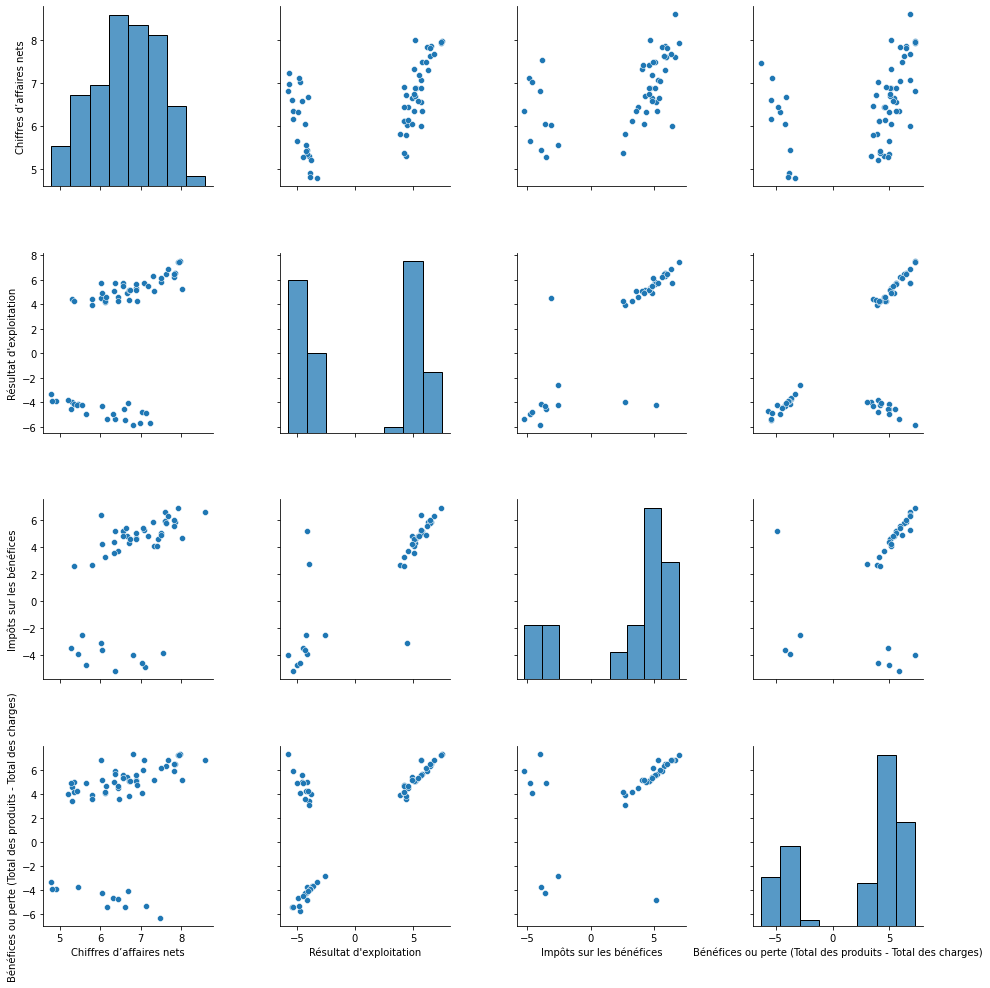

In [ ]:
# Pairplot en fonction de {FJ:"Chiffres d’affaires nets", GG:"Résultat d'exploitation", HN:"Dividendes"}
sns.pairplot(entreprises.loc[:,obtention_col(['FJ', 'GG', 'HN', "HK"])], height=3.5)#, hue="optimisation_fiscale")

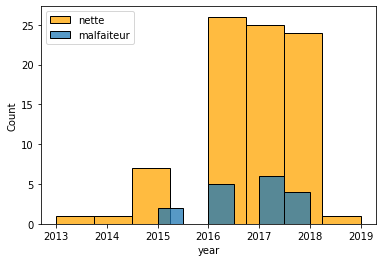

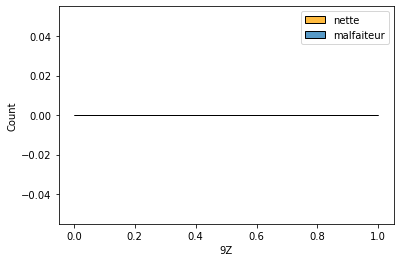

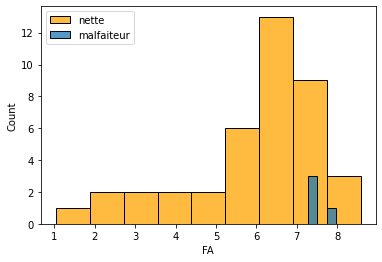

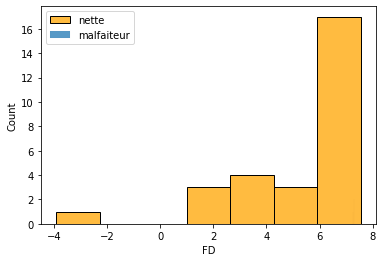

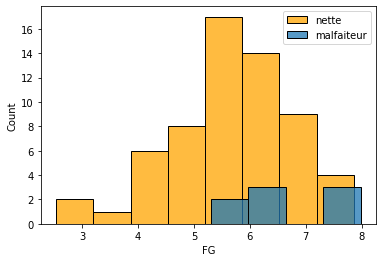

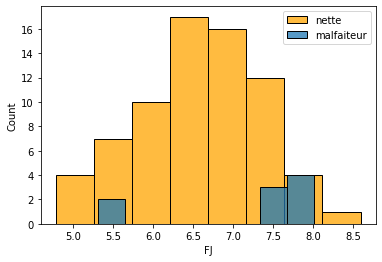

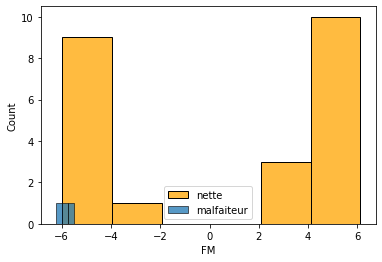

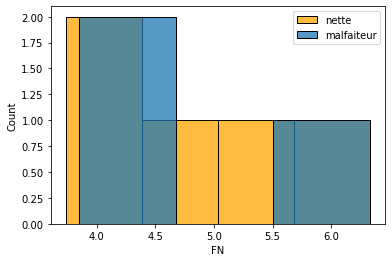

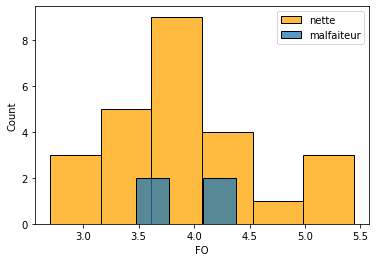

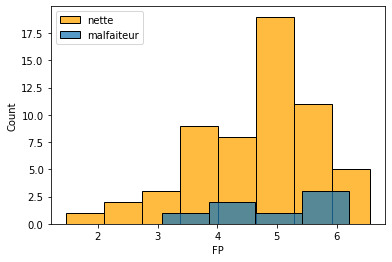

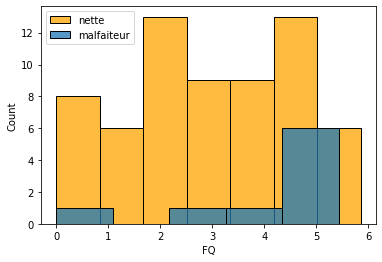

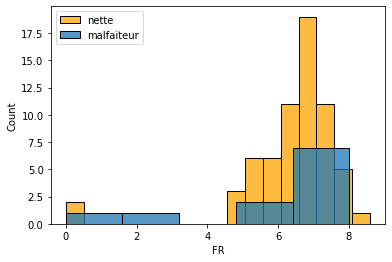

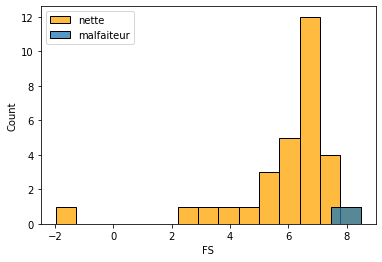

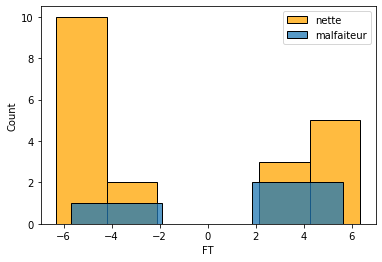

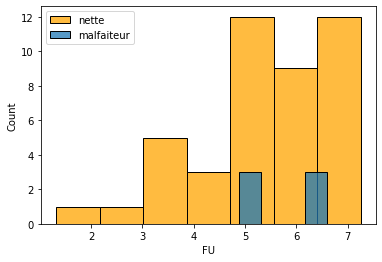

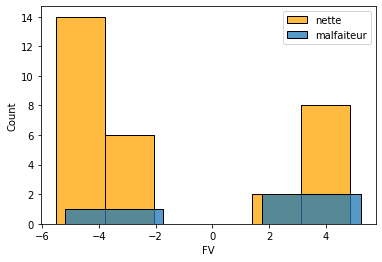

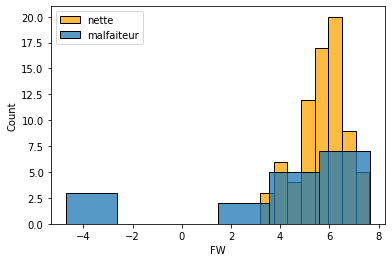

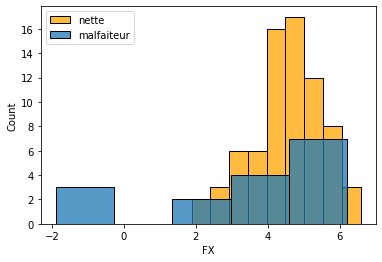

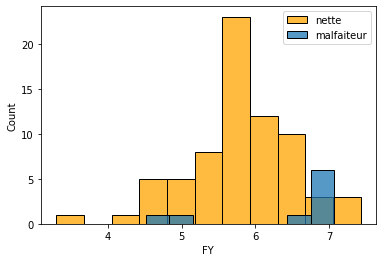

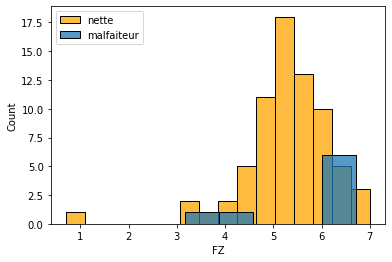

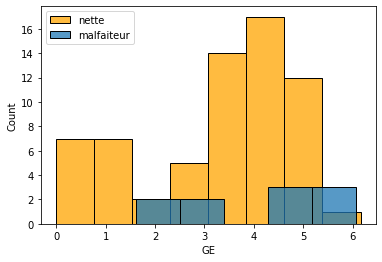

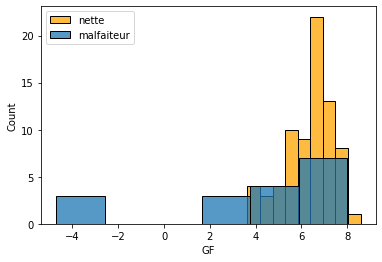

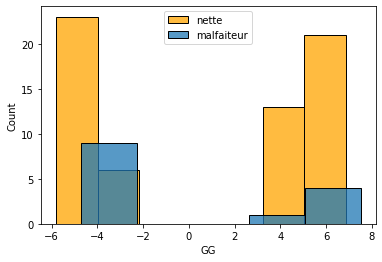

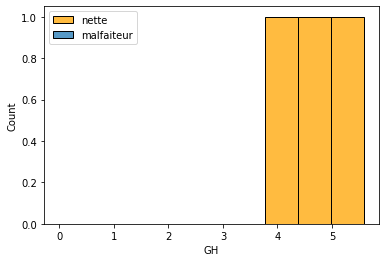

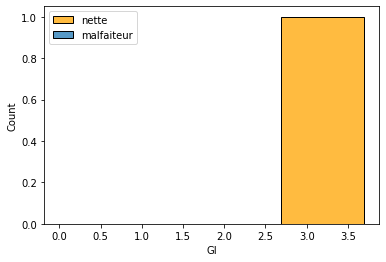

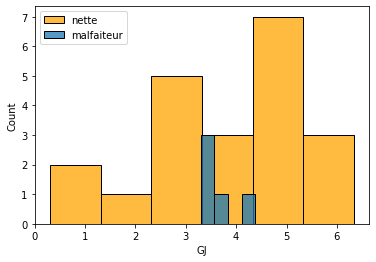

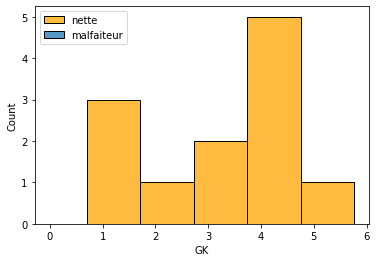

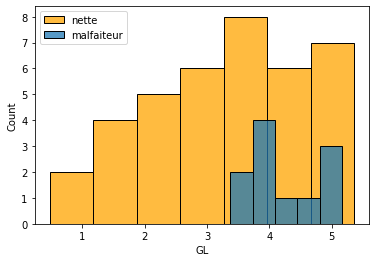

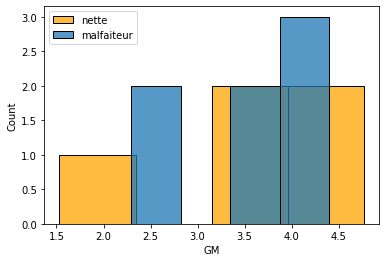

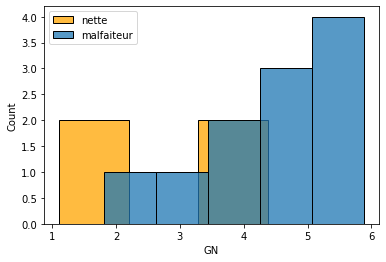

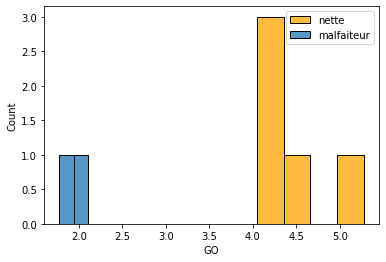

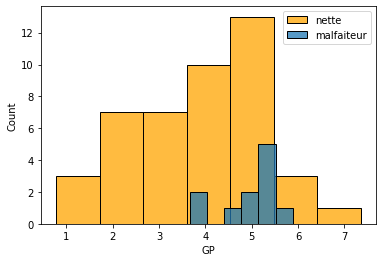

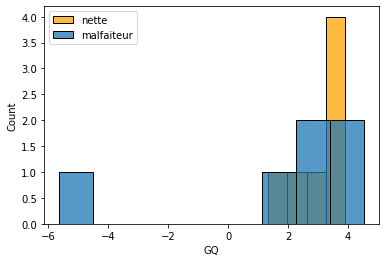

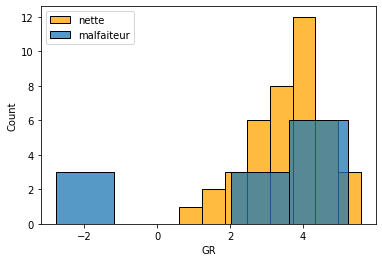

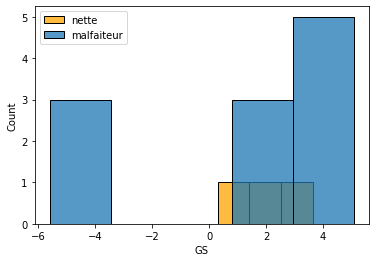

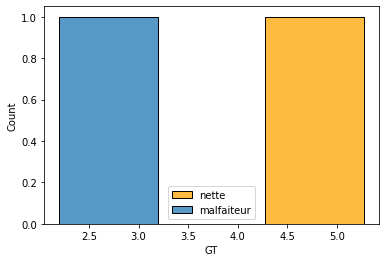

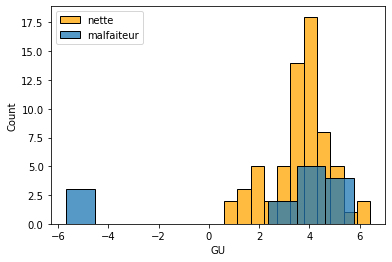

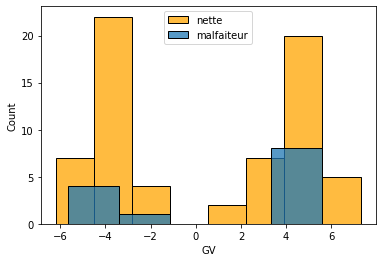

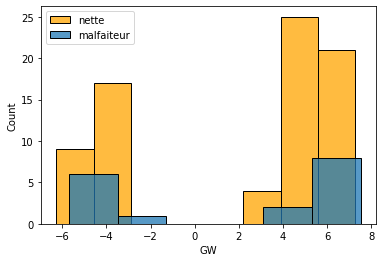

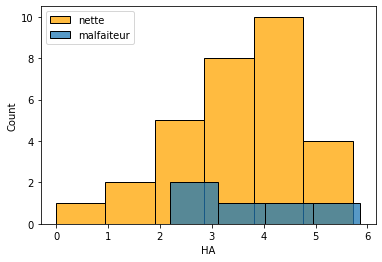

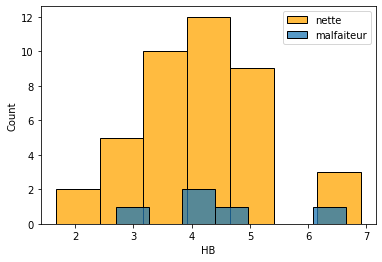

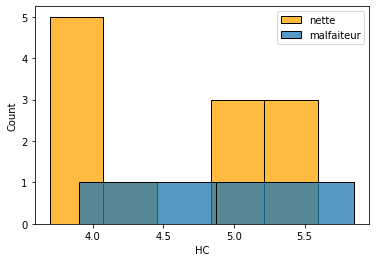

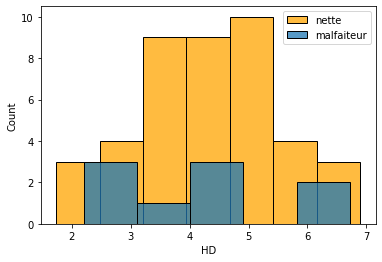

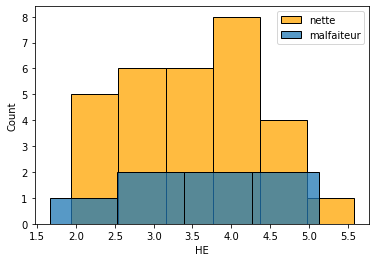

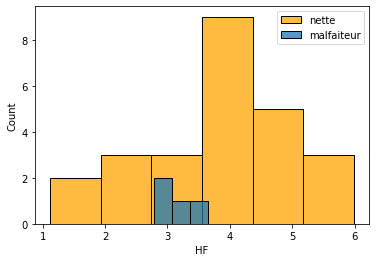

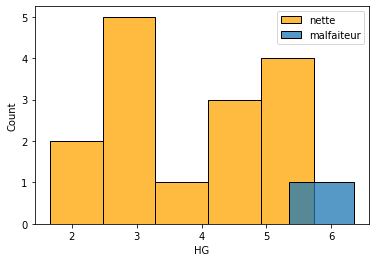

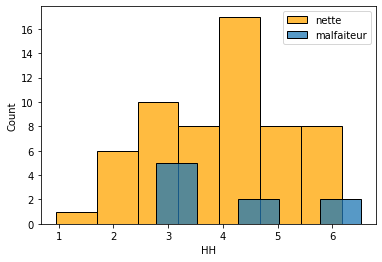

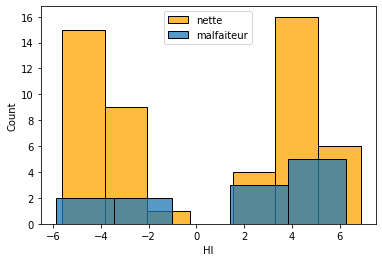

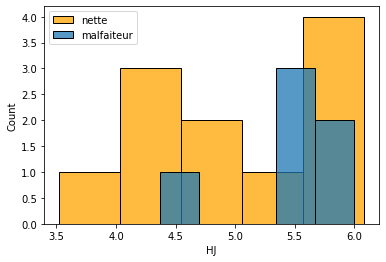

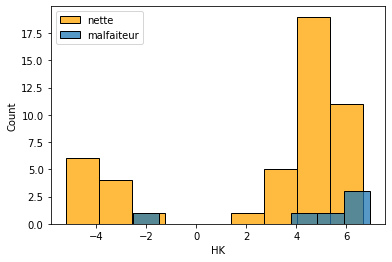

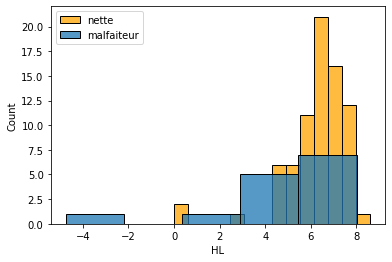

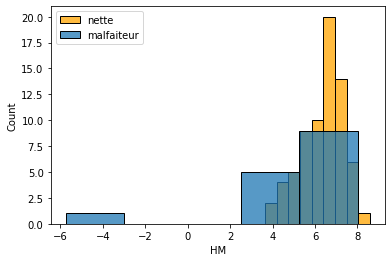

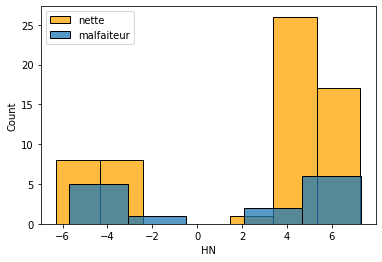

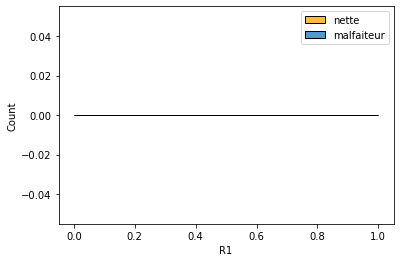

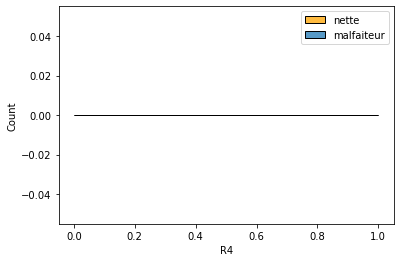

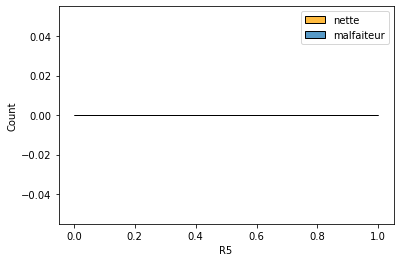

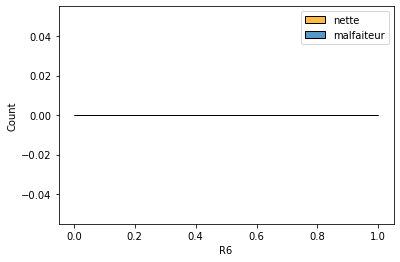

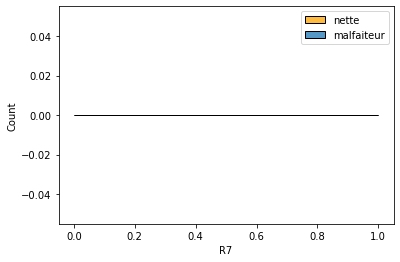

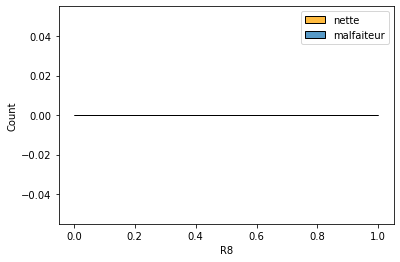

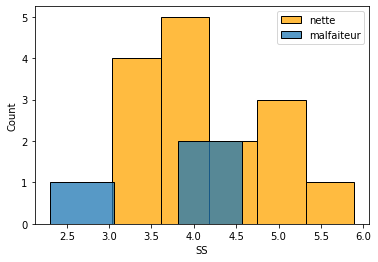

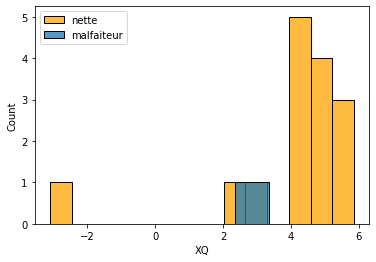

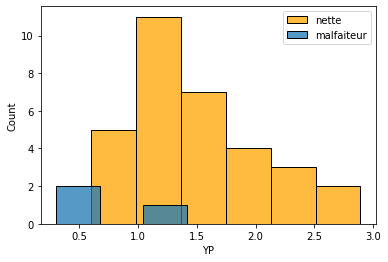

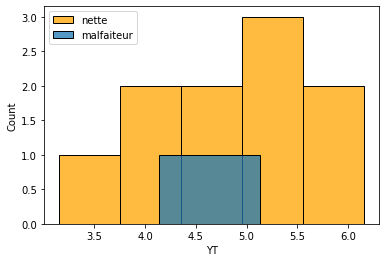

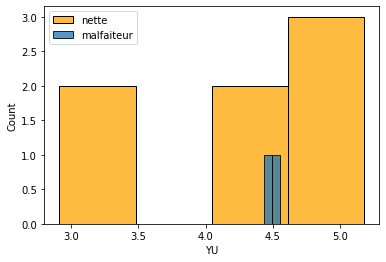

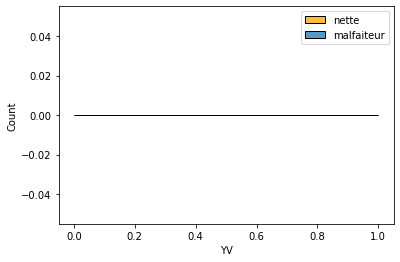

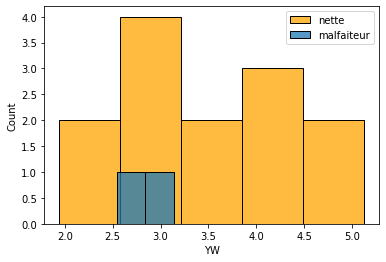

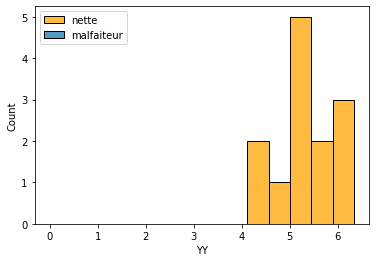

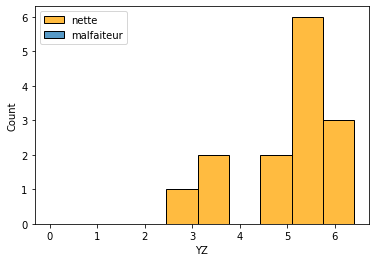

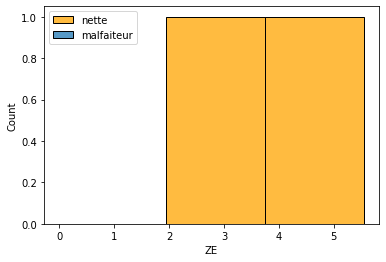

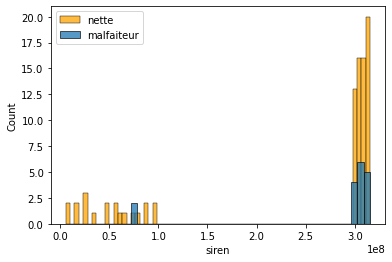

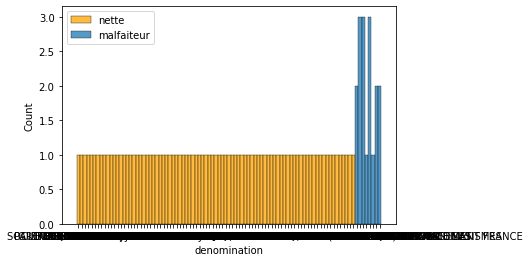

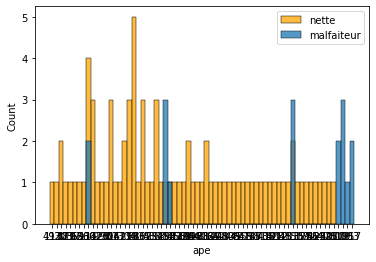

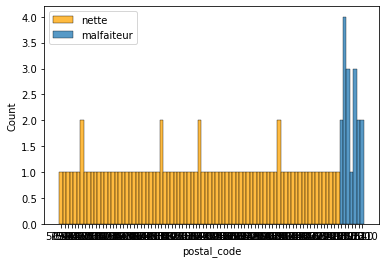

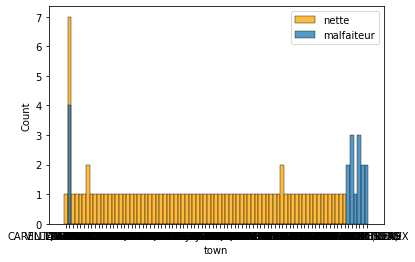

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


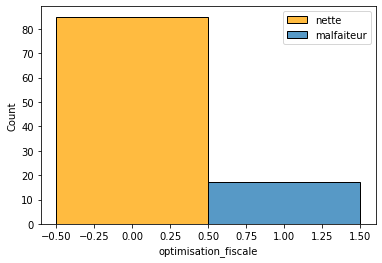

ConversionError: ignored

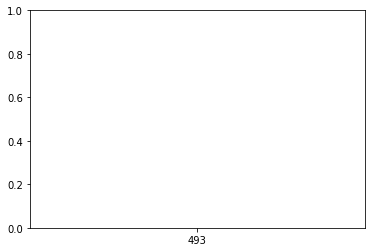

In [ ]:
#@title Titre par défaut
for col in data.columns:
    sns.histplot(entreprise_nette[col], label='nette', color='orange')
    sns.histplot(entreprise_malfaiteur[col], label='malfaiteur')
    plt.legend()
    plt.plot()
    plt.show()

In [ ]:
data.loc[:,obtention_col(["HN", "HK"])]

,Impôts sur les bénéfices,Bénéfices ou perte (Total des produits ‐ Total des charges)
0,-3.768786,NaN
1,-4.406285,NaN
2,-4.471600,NaN
3,NaN,-4.248978
4,-3.454540,3.388456
...,...,...
35665,-3.563481,4.496957
35666,3.461948,4.410592
35667,4.988728,NaN
35668,3.558829,4.346099


Il semble que les variables :
- FG "Production service rendue
- FJ 	"Chiffres d’affaires nets"
- FN "Production immobilisée"
- FR "Total des produits d’exploitation"
- HD "Total des produits exceptionnels"
- HJ "Participation des salariés aux résultats de l’entreprise"
puissent être utilisées pour déterminer si une entreprise pratique de l'optimisation fiscale ou non.

Des tests statistiques (test de Student) sont à réalisés pour vérifier ces hypothèses.

# Sauvegarde des données par catégorie

In [ ]:
data[data['ape_cat0']=='45'].to_excel('data.xlsx')

In [ ]:
#with open('/content/gdrive/My Drive/Impact Score/Export données par catégorie/data.xlsx', 'w') as f:
data[data['ape_cat0']=='45'].to_excel('/content/gdrive/My Drive/Impact Score/Export données par catégorie/data.xlsx')

In [ ]:
for j in ['0' + str(i) for i in range(0,10)]+ [str(i) for i in list(range(10,data['ape_cat0'].dropna().astype(int).max() +1))]:
  data[data['ape_cat0']==str(j)].to_excel('/content/gdrive/My Drive/Impact Score/Export données par catégorie/data{}.xlsx'.format(j))
  print(j)

00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
